## EDA

In [2]:
import pandas as pd
import seaborn as sns
sns.set()                            # permite setear parámetros de estilo en los gráficos
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [4]:
dfn = pd.read_parquet('dataSets\\train.parquet')

In [5]:
dfn.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7048013474,https://boise.craigslist.org/apa/d/very-nice-b...,boise,https://boise.craigslist.org,1350,house,1200,2,2.0,1,...,0,0,0,w/d in unit,detached garage,https://images.craigslist.org/00B0B_cPiJMEheZe...,Super cute row house in the Boise bench area. ...,43.5851,-116.2250,id
1,7043931179,https://cosprings.craigslist.org/apa/d/colorad...,colorado springs,https://cosprings.craigslist.org,1115,apartment,694,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00R0R_5XAoSKvfrz...,Windtree Apartment Homes currently has a spaci...,38.9137,-104.7800,co
2,7048254516,https://norfolk.craigslist.org/apa/d/virginia-...,norfolk / hampton roads,https://norfolk.craigslist.org,1129,apartment,900,2,2.0,0,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00f0f_3ZbTFrsHpZ...,Call Today! show contact info Indian Lakes ...,36.7922,-76.1643,va
3,7041032577,https://phoenix.craigslist.org/nph/apa/d/phoen...,phoenix,https://phoenix.craigslist.org,1580,house,1469,3,2.0,1,...,0,0,0,w/d in unit,None,https://images.craigslist.org/00f0f_aXV5Dkd5qk...,Cody Anderson Two Brothers Realty License #: S...,33.5623,-112.0560,az
4,7048588701,https://nashville.craigslist.org/apa/d/antioch...,nashville,https://nashville.craigslist.org,995,apartment,700,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00606_gYOGKClOHv...,To schedule a tour We now book our tour appoin...,36.0595,-86.6592,tn


In [6]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346479 entries, 0 to 346478
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       346479 non-null  int64  
 1   url                      346479 non-null  object 
 2   region                   346479 non-null  object 
 3   region_url               346479 non-null  object 
 4   price                    346479 non-null  int64  
 5   type                     346479 non-null  object 
 6   sqfeet                   346479 non-null  int64  
 7   beds                     346479 non-null  int64  
 8   baths                    346479 non-null  float64
 9   cats_allowed             346479 non-null  int64  
 10  dogs_allowed             346479 non-null  int64  
 11  smoking_allowed          346479 non-null  int64  
 12  wheelchair_access        346479 non-null  int64  
 13  electric_vehicle_charge  346479 non-null  int64  
 14  come

### Chequeo y tratamiento de valores nulos 

La función de abajo recorre el dataframe, suma los valores faltantes en cada campo. Por último, devuelve el porcentaje de nulos en cada columna.

In [7]:
def get_nan_in_df(dataFrame):
    # contabilizar los valores nulos en cada columna del data frame, organizarlas por cantidad de nulos.
    nanValues = dataFrame.isna().sum().sort_values(ascending=False)
    # calcular ese número en porcentaje
    nanValuesPrct = (nanValues/len(dataFrame) )*100
    
    return nanValuesPrct

In [8]:
get_nan_in_df(dfn)

parking_options            36.562678
laundry_options            20.541216
long                        0.497000
lat                         0.497000
description                 0.000577
id                          0.000000
url                         0.000000
image_url                   0.000000
comes_furnished             0.000000
electric_vehicle_charge     0.000000
wheelchair_access           0.000000
smoking_allowed             0.000000
dogs_allowed                0.000000
cats_allowed                0.000000
baths                       0.000000
beds                        0.000000
sqfeet                      0.000000
type                        0.000000
price                       0.000000
region_url                  0.000000
region                      0.000000
state                       0.000000
dtype: float64

Debido al alto porcentaje de valores nulos en las columnas 'parking_options' y 'laundry_options', 36.6% y 20.54% respectivamente, vamos a eliminar estas dos columnas

In [9]:
dfn.drop(columns = ['parking_options', 'laundry_options'], inplace=True)

Ahora, que no quedan columnas con alto porcentaje de valores nulos, eliminemos los valores faltantes por fila.

In [10]:
dfn = dfn[dfn.long.isna() == False]

In [11]:
#get_nan_in_df(dfn)

Parece que los campos 'long' y 'lat' tenían valores nulos exactamente en los mismos registros. Solo quedan valores faltantes en la columna 'description' que es un campo que eliminaremos más tarde.

### Eliminar campos irrelevantes

Vamos a eliminar los campos 'image_url' y 'url' debido a que consideramos que no podemos obtener datos adicionales relevantes de estas direcciones.
Sin embargo, vamos a mantener el campo 'region_url' dado que podría ayudarnos en caso de que los datos en la columna 'region' sean ambigüos. Por otra parte, no guarda ninguna información del inmueble más que su código de identificación, por lo tanto también será eliminado.

In [12]:
dfn.drop(columns = ['url','image_url','id'], inplace=True)

### Normalización de las columnas de texto

In [13]:
# Lista basada en string.punctuation
punctuation = ['!','"','#','$','~','%','&','\'','(',')','*','+',',','-','.','/',':',';',
               '<','=','>','?','@','[','\\',']','^','_','`','{','|','}']

In [14]:
def find_punctuation(a_string):
    for element in punctuation:
            if element in a_string:
                return True
    return False       

In [15]:
# buscar puntuación en el campo region
dfPunt = dfn[dfn.region.apply(find_punctuation)]

'region' tiene nombres separados por barras, posiblemente el segundo nombre sea de un barrio dentro de la ciudad

In [16]:
#dfPunt 

In [17]:
def limpiar_url(url):
    url = url.replace('https://','')
    url = url.split('.')[0]
    return url

In [18]:
dfn.region_url = dfn.region_url.apply(limpiar_url)

In [19]:
region_url = dfn.region_url.value_counts().reset_index()

In [20]:
#region_url

In [21]:
dfPunt = dfn[dfn.region_url.apply(find_punctuation)]

In [22]:
dfPunt

,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,description,lat,long,state


Ninguno de los datos en region_url tiene puntuación. Por otra parte, varias celdas en la columna 'region' tienen dos datos. Como los datos de 'region_url' han sido normalizados, y cotienen la misma información que los de 'region', eliminaremos a esta última.

In [23]:
dfn.drop(columns= 'region', inplace = True)

In [24]:
dfn.rename(columns = {'region_url' : 'region'}, inplace = True)

In [25]:
region = dfn.region.value_counts().reset_index()

### Column 'type'

In [26]:
dfn.type.value_counts()

apartment          285141
house               29543
townhouse           14147
condo                5591
duplex               4512
manufactured         3813
cottage/cabin         765
loft                  615
flat                  468
in-law                152
land                    8
assisted living         2
Name: type, dtype: int64

Cambiemos la barra en el valor 'cottage/cabin', ya que podría traer complicaciones más tarde,cuando creemos una columna con ese nombre al utilizar one-hot encoding.

In [27]:
dfn.type = dfn.type.apply(lambda x: x.replace('/','_'))

Lo mismo para la columna 'in-law'

In [28]:
dfn.type = dfn.type.apply(lambda x: x.replace('-','_'))

In [29]:
#dfn.type.value_counts()

### Columna 'state'

In [30]:
# dfn.state.value_counts()

Por lo que pudimos apreciar, esta columna no presenta anormalidades

### Puntos geográficos

In [31]:
import geopandas

In [32]:
gdf = geopandas.GeoDataFrame(
    dfn, geometry=geopandas.points_from_xy(dfn.long, dfn.lat))

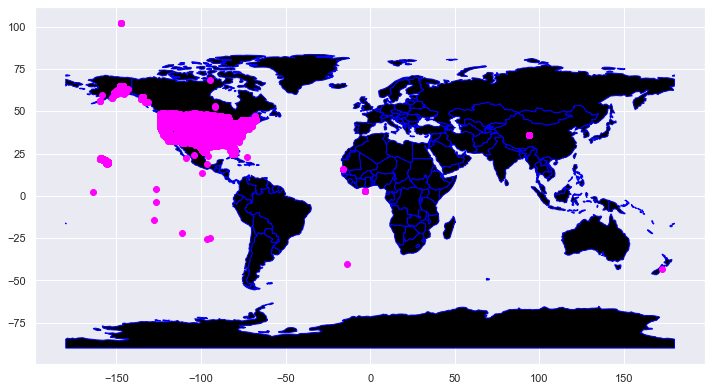

In [33]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(
    color='black', edgecolor='blue', figsize=(12,12))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='fuchsia')

plt.show()

A primera vista lo que notamos es lo siguiente: por un lado, el territorio de Estados Unidos se encuentra cubierto de puntos.
Por el otro hay puntos desperdigados por todo el mundo. Algunos se ven en Canadá, otros en Alaska, además hay una masa de puntos concentrados
cerca del meridiano 25 y el paralelo -160 aprox. eso debe ser Hawai. Sin embargo hay otros puntos en el Pacífico más alejados de lo que
creemos es Hawai, habrá que investigarlos. Los puntos sobre el Atlántico, África, China y el sur de Oceanía también son sospechosos
de ser valores erróneos. 

Para realizar la limpieza de estos datos vamos a imaginar un rectángulo que cubra la superficie continental de Los Estados
Unidos, exceptuando a Alaska. Las líneas que delimitan este rectángulo están dadas por: 

In [34]:
meridiano_norte = 49.25   # latitud
meridiano_sur = 24.5      # latitud
paralelo_este = -67       # long
paralelo_oeste = -124.5   # long

Investiguemos los puntos por fuera de este rectángulo y que no pertenezcan a los Estados de Alaska ni Hawai.

Para estar fuera del rectángulo, los puntos deben estar o bien por encima del meridiano 49,25, o por debajo del 24,5. Además, deben estar al este del paralelo -67 o estar al oeste del -124,5. Las cuatro condiciones conforman una suma lógica y lo expresamos de la siguiente manera:

In [35]:
outers = dfn[(dfn.lat > meridiano_norte) | (dfn.lat< meridiano_sur) |
             (dfn.long > paralelo_este) | (dfn.long < paralelo_oeste)]

In [36]:
#outers.state.value_counts()

De estos solo nos interesan aquellos que no sean de Alaska ni Hawai

In [37]:
outers = outers[(outers.state != 'ak') & (outers.state != 'hi')]

In [38]:
err_prctj = round((len(outers)/len(dfn)) *100, 2)
print(f'Los puntos mal ubicados representan un {err_prctj} % del total')

Los puntos mal ubicados representan un 0.07 % del total


Podríamos eliminarlos, pero procederemos a corregir algunos para dejar asentado como se soluciona esta clase de inconvenientes.

In [39]:
#outers.state.value_counts()

La mayoría de estos registros tienen 'ar' como valor en la columna state, así que vamos a tratar de corregir estos datos.

In [40]:
# Veamos que muestran las coordenadas de Arkansas en el DF original.
#dfn[dfn.state == 'ar'] 

La longitud de Arkansas está alrededor - 94.xxxx, por lo tanto los datos con similar longitud pero de signo opuesto pueden ser
corregidos multiplicandolos por -1. Los datos de la longitud fueron reafirmados al investigar en Google Maps.

In [41]:
# buscamos los registros de Arkansas al este del cuadraro imaginario que trazamos
outers_ar = outers[(outers.state == 'ar') & (outers.long > -67)]

In [42]:
# obtenemos una lista de índices para realizar cambios en el data frame original
indices = outers_ar.long.index.to_list()

In [43]:
# contrastamos la longitud del data frame con la de la lista de índices, deberían tener igual tamaño.
len(outers_ar) - len(indices)

0

In [44]:
# Cambiar los valores del campo 'long' para los índices proporcionados
for indice in indices:
    dfn.at[indice,'long'] = dfn.at[indice,'long'] *-1

__Pasos de comprobación__

In [45]:
# volvemos a crear un dataframe conteniendo todas las condiciones necesarias para estar fuera del territorio continental
outers = dfn[(dfn.lat > meridiano_norte) | (dfn.lat< meridiano_sur) |
             (dfn.long > paralelo_este) | (dfn.long < paralelo_oeste)]

In [46]:
# Y pedimos nuevamente excluir a Alaska y a Hawai
outers = outers[(outers.state != 'ak') & (outers.state != 'hi')]

In [47]:
len(outers)

30

Solamente quedaron 30 registros, procederemos a eliminarlos

In [48]:
# creamos una lista de índices para luego poder mapear los índices del dataframe original
indices = outers.region.index.to_list()
len(outers) - len(indices)   # chequeamos que los tamaños se correspondan

0

In [49]:
# eliminamos los datos en el data frame original
dfn.drop(indices, inplace = True)

Luego de aplicar todos los pasos, volvimos a graficar nuestros datos y notamos que existe al menos un punto sobre el océano Pacífico, vamos a investigarlo.

In [50]:
outers = dfn[dfn.lat < 15]

In [51]:
outers

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,description,lat,long,state,geometry
215976,honolulu,1788,condo,570,2,1.0,1,0,0,0,0,1,Stunning views on the ocean and beach from mos...,2.20183,-163.894,hi,POINT (-163.89400 2.20183)


Es un solo registro, que muestra coordenadas erróneas para la región de Honolulu, podríamos imputarle un valor, pero lo eliminaremos.

In [52]:
dfn.drop(215976, inplace = True)

## Por el momento, no vamos a seguir teniendo en cuenta las características geográficas. Tampoco realizaremos análisis de texto.

In [53]:
dfn.drop(columns=['region','description','lat','long','state', 'geometry'], inplace = True)

In [54]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344726 entries, 0 to 346478
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   price                    344726 non-null  int64  
 1   type                     344726 non-null  object 
 2   sqfeet                   344726 non-null  int64  
 3   beds                     344726 non-null  int64  
 4   baths                    344726 non-null  float64
 5   cats_allowed             344726 non-null  int64  
 6   dogs_allowed             344726 non-null  int64  
 7   smoking_allowed          344726 non-null  int64  
 8   wheelchair_access        344726 non-null  int64  
 9   electric_vehicle_charge  344726 non-null  int64  
 10  comes_furnished          344726 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 31.6+ MB


## Búsqueda y tratamiento de outliers

En esta sección buscaremos valores atípicos en los campos 'price', 'sqfeet', 'beds' y 'baths'. En cuanto las otras columnas numéricas, ya habíamos comprobado más arriba que contienen valores binarios.

Las cuatro columnas mencionadas arriba presentaron outliers. Por lo tanto, vamos usar la regla intercuartil y el método de winzorización para tratar con estos. En primer lugar, con la regla intercuartil hallaremos los límites superiores e inferiores. Luego, llevaremos nuestros valores atípicos al límite más cercano con el método de winzorización. De esta manera, los valores atípicos altos tomarán el valor del límite superior, establecido con la regla intercuartil, mientras que a los valores atípicos bajos se les imputará el valor del límite inferior, siempre que este sea un resultado válido.

__Funciones para el cálculo del rango intercuartil__

Solo utilizaremos las dos primeras, las tres últimas son funciones auxiliares.

In [55]:
# Obtener el límite superior 
def get_upper_limit(campo, data_frame):
    upper_lim = get_quartile_three_value(campo, data_frame) + 1.5*get_iqr(campo, data_frame)
    return upper_lim

In [56]:
# Obtener el valor límite inferior 
def get_lower_limit(campo, data_frame):
    lower_lim = get_quartile_one_value(campo, data_frame) - 1.5*get_iqr(campo, data_frame)
    return lower_lim      

In [57]:
# Obtener el rango intercuartil
def get_iqr(campo, data_frame):
    IQR = get_quartile_three_value(campo, data_frame) - get_quartile_one_value(campo, data_frame)
    return IQR

In [58]:
# calcular el primer cuartil
def get_quartile_one_value(campo, data_frame):
    Q1 = data_frame[campo].quantile(0.25)
    return Q1

In [59]:
# calcular el tercer cuartil
def get_quartile_three_value(campo, data_frame):
    Q3 = data_frame[campo].quantile(0.75)
    return Q3

### Columna 'price'

Comencemos viendo la 'forma' general de los datos.

<AxesSubplot:xlabel='price', ylabel='Count'>

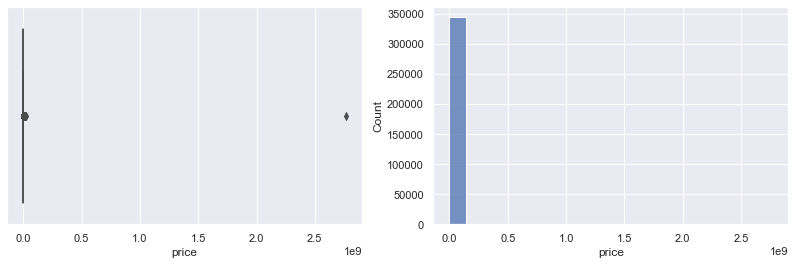

In [60]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='price', data=dfn, ax=axs[0])
sns.histplot(x='price', data=dfn, bins=20, kde=False, ax=axs[1])

In [61]:
#dfn.loc[dfn['price'].idxmax()]

Como podemos ver, incluso gráficamente es dificil notar la distribución de este campo. Sin embargo parece estar sesgada a la derecha. 

In [62]:
dfn[['price']].describe()

,price
count,3.447260e+05
mean,9.705588e+03
std,4.715517e+06
min,0.000000e+00
25%,8.060000e+02
50%,1.035000e+03
75%,1.395000e+03
max,2.768307e+09


In [63]:
outliers_low = (dfn['price'] < get_lower_limit('price', dfn)).value_counts()
outliers_low

False    344726
Name: price, dtype: int64

In [64]:
outliers_high = (dfn['price'] > get_upper_limit('price', dfn)).value_counts()
outliers_high

False    327839
True      16887
Name: price, dtype: int64

__Winsorización__

In [65]:
lim_inferior = get_lower_limit('price', dfn)
lim_inferior

-77.5

El límite inferior es negativo, pero en este caso, ese número no es válido para una cantidad. Por lo tanto, tomaremos al cero como nuestro límite inferior.

In [66]:
lim_superior = get_upper_limit('price', dfn)
lim_superior

2278.5

Veamos que cuantiles que quedan comprendidos en el rango entre límites son los más próximos a estos límites

In [67]:
dfn['price'].quantile(0.00) 

0.0

En el caso del límite inferior, el primer cuantil es igual al límite inferior. Este será el cuantil inferior que utilizaremos.

Sigamos con la parte superior 

In [68]:
dfn['price'].quantile(0.95)    # el cuantil 0.96 es mayor que el límite superior

2260.0

Ya tenemos nuestros dos cuantiles, es hora de tratar los outliers

In [69]:
# Escribimos los límites como percentiles, el primer parámetro es el primer percentil, 
# el segundo es el percentil 95(5 contado de atrás hacia adelante)
dfn['price'] = winsorize(dfn['price'],(0.00, 0.05)) 

Veamos como quedaron nuestros datos

<AxesSubplot:xlabel='price', ylabel='Count'>

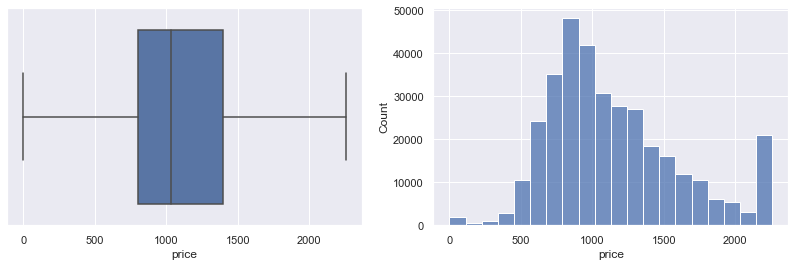

In [70]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='price', data=dfn, ax=axs[0])
sns.histplot(x='price', data=dfn, bins=20, kde=False, ax=axs[1])

Perfecto, nos deshicimos de los outliers.

A primera vista quizás parezca un cambio muy drástico, debido a que al corregir los outliers los precios más altos han caído
drasticamente. Sin embargo, siguen estando dentro de la categoría de inmuebles caros, por lo que esta estrategia tiene mucho
sentido. Distinto sería el caso en que tuviésemos que predecir precios. 

### Columna 'sqfeet'

<AxesSubplot:xlabel='sqfeet', ylabel='Count'>

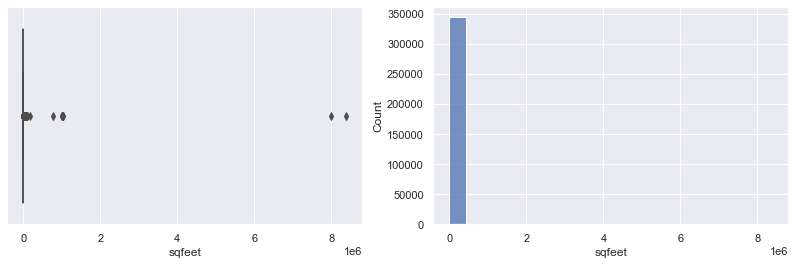

In [71]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='sqfeet', data=dfn, ax=axs[0])
sns.histplot(x='sqfeet', data=dfn, bins=20, kde=False, ax=axs[1])

Se ve similar a la distribución del campo anterior.

In [72]:
outliers_low = (dfn['sqfeet'] < get_lower_limit('sqfeet', dfn)).value_counts()
outliers_low

False    343739
True        987
Name: sqfeet, dtype: int64

Pero este campo si posee outliers del lado izquierdo de la distribución.

__Winsorización__

Los pasos a seguir son los mismos descriptos para el campo 'price'

In [73]:
lim_inferior = get_lower_limit('sqfeet', dfn)
lim_inferior

151.5

In [74]:
lim_superior = get_upper_limit('sqfeet', dfn)
lim_superior

1747.5

In [75]:
dfn['sqfeet'].quantile(0.01) # el primer percentil vale 0, pero queda por debajo del límite inferior

340.0

In [76]:
dfn['sqfeet'].quantile(0.96)

1737.0

In [77]:
dfn['sqfeet'] = winsorize(dfn['sqfeet'],(0.01, 0.04)) 

<AxesSubplot:xlabel='sqfeet', ylabel='Count'>

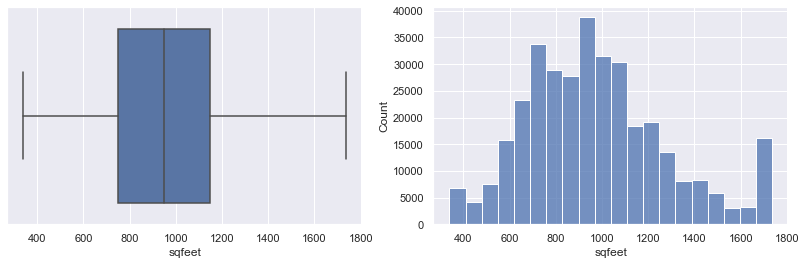

In [78]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='sqfeet', data=dfn, ax=axs[0])
sns.histplot(x='sqfeet', data=dfn, bins=20, kde=False, ax=axs[1])

### Columna 'beds'

<AxesSubplot:xlabel='beds', ylabel='Count'>

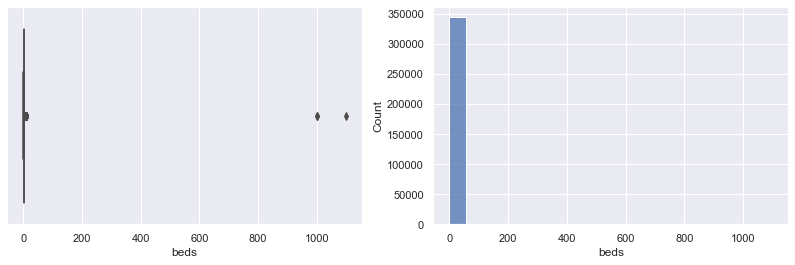

In [79]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='beds', data=dfn, ax=axs[0])
sns.histplot(x='beds', data=dfn, bins=20, kde=False, ax=axs[1])

Otra vez vemos lo que pareciera ser una distribución muy sesgada a la derecha.

In [80]:
outliers_low = (dfn['beds'] < get_lower_limit('beds', dfn)).value_counts()
outliers_low

False    344726
Name: beds, dtype: int64

En efecto, vimos que hay outliers muy a la derecha, pero no hay outliers por debajo del límite inferior

In [81]:
lim_inferior = get_lower_limit('beds', dfn)
lim_inferior

-0.5

De nuevo como pasó con los precios, el límite inferior es negativo. Por lo tanto, asignaremos el cero al límite inferior.

In [82]:
lim_inferior = 0

In [83]:
lim_superior = get_upper_limit('beds', dfn)
lim_superior

3.5

In [84]:
dfn['beds'].quantile(0.00) 

0.0

In [85]:
dfn['beds'].quantile(0.96)

3.0

In [86]:
dfn['beds'] = winsorize(dfn['beds'],(0.00, 0.04)) 

<AxesSubplot:xlabel='beds', ylabel='Count'>

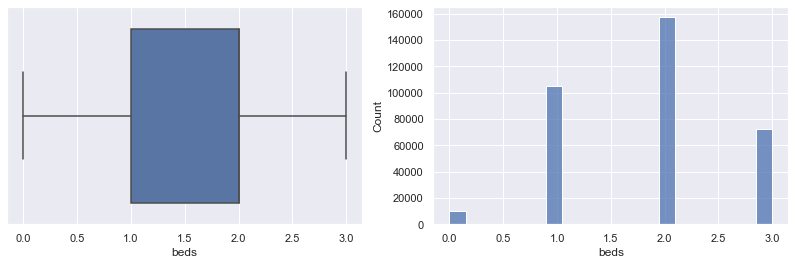

In [87]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='beds', data=dfn, ax=axs[0])
sns.histplot(x='beds', data=dfn, bins=20, kde=False, ax=axs[1])

### Columna 'baths'

<AxesSubplot:xlabel='baths', ylabel='Count'>

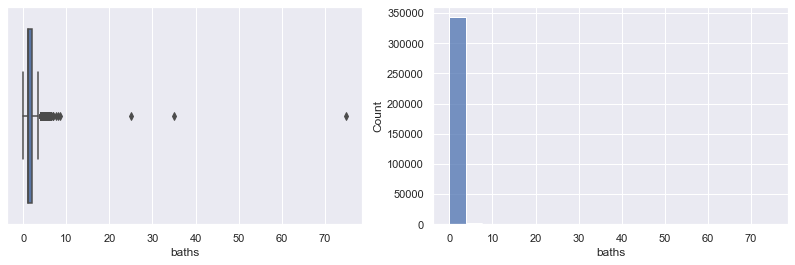

In [88]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='baths', data=dfn, ax=axs[0])
sns.histplot(x='baths', data=dfn, bins=20, kde=False, ax=axs[1])

In [89]:
outliers_low = (dfn['baths'] < get_lower_limit('baths', dfn)).value_counts()
outliers_low

False    344726
Name: baths, dtype: int64

Una vez más vemos que la distribución de los datos está sesgada a la derecha.

__Winsorización__

Los pasos a seguir son los mismos descriptos para el campo 'price'

In [90]:
lim_inferior = get_lower_limit('baths', dfn)
lim_inferior

-0.5

In [91]:
# redefinimos el límite inferior por ser un valor inválido
lim_inferior = 0

In [92]:
lim_superior = get_upper_limit('baths', dfn)
lim_superior

3.5

In [93]:
dfn['baths'].quantile(0.00) 

0.0

In [94]:
dfn['baths'].quantile(0.98)

3.0

In [95]:
dfn['baths'] = winsorize(dfn['baths'],(0.00, 0.02)) 

<AxesSubplot:xlabel='baths', ylabel='Count'>

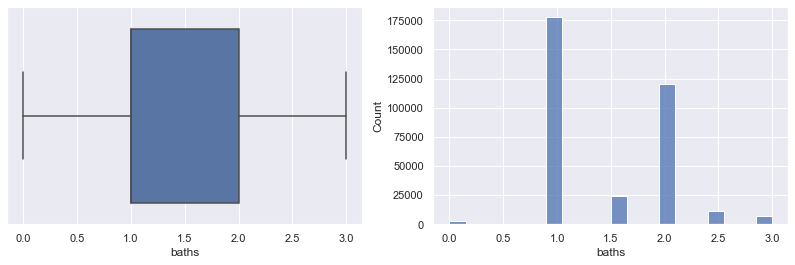

In [96]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='baths', data=dfn, ax=axs[0])
sns.histplot(x='baths', data=dfn, bins=20, kde=False, ax=axs[1])

Ahora que no tenemos outliers podemos proseguir.

## One-Hot Encoding

En este paso vamos a tomar los valores únicos del campo 'type' y convertirlos en columnas binarizadas. 

In [97]:
ohe = OneHotEncoder()          # crear un objeto OneHotEncoder
transformed = ohe.fit_transform(dfn[['type']])  # prepara la columna mencionada
#print(transformed.toarray())

In [98]:
# Codifica a ceros y unos todas las categorías del campo elegido. Luego agrega las nuevas columnas al DF
dfn[ohe.categories_[0]] = transformed.toarray() 

In [99]:
# Ya convertimos las categorías a números, podemos eliminar la columna type
dfn.drop(columns = 'type', inplace = True)

## Búsqueda de correlaciones entre los campos numéricos

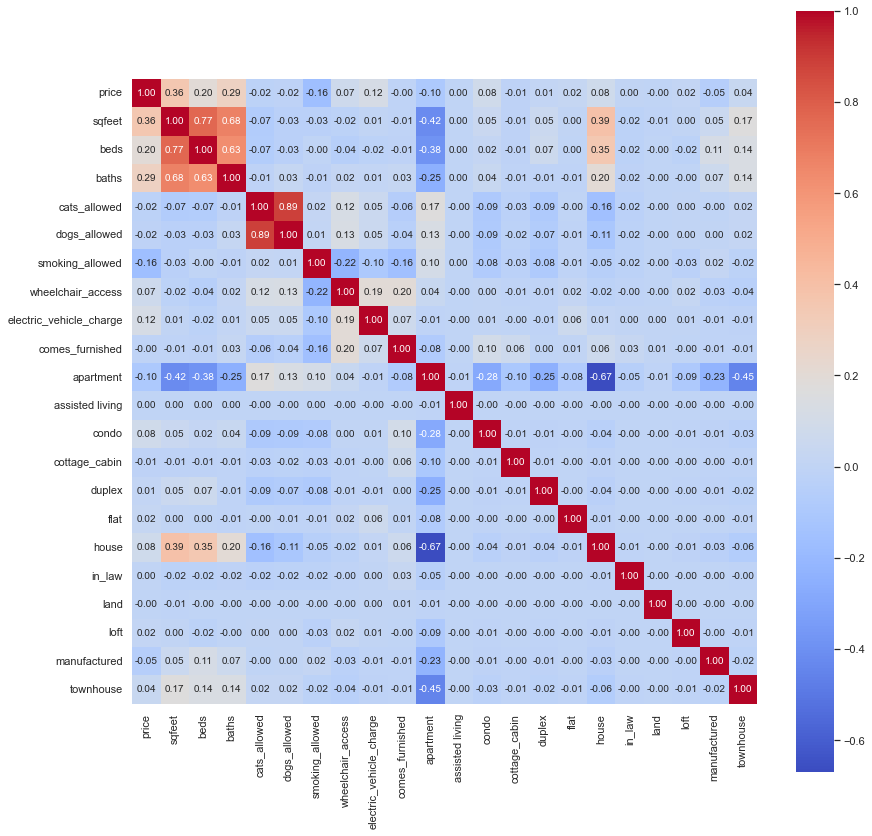

In [100]:
# Realizamos el mapa de calor para ver la correlación entre las variables
corr = dfn.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           xticklabels= dfn.columns, 
           yticklabels= dfn.columns,
           cmap= 'coolwarm')
plt.show()

Los campos 'dogs_allowed' y 'cats_allowed' tienen una correlación de 0,89. Por consiguiente, eliminaremos la última.

In [101]:
dfn.drop(columns = 'cats_allowed', inplace = True)

## Creación de la columna objetivo

Implementar un modelo de clasificación con aprendizaje supervisado que permita clasificar el precio de las propiedades en venta, utilizando los datos que se han puesto a su disposición. Para esto debe crear la columna category_price, en la cual se consideran las categorías
- 'low': Para precios entre 0 y 999 dólares.
- 'medium': Para precios entre 1000 y 1999 dólares.
- 'high': Para precios desde 2000 dólares en adelante.

Considerando esta categorización, el objetivo es predecir si una propiedad pertenece a la categoría de precios bajos (low).

In [102]:
# Añademos la columna 'target', inicializamos sus celdas con valor = 0
dfn['target'] = 0

In [103]:
# A los registros con precio menor o igual que 999 les asignaremos 1 como valor
dfn.loc[dfn['price'] <= 999, 'target'] = 1

In [104]:
dfn[dfn.price <= 999].price.value_counts().sum()

159974

### Eliminamos la columna 'price'

In [105]:
dfn.drop(columns ='price', inplace = True)

In [106]:
dfn.to_csv('dataSetEntrenamieno.csv')

# Set de testeo

In [107]:
dfs = pd.read_parquet('dataSets\\test.parquet')

## Chequeo y tratamiento de valores nulos

In [108]:
get_nan_in_df(dfs)

parking_options            36.378513
laundry_options            20.403657
long                        0.509117
lat                         0.509117
id                          0.000000
wheelchair_access           0.000000
description                 0.000000
image_url                   0.000000
comes_furnished             0.000000
electric_vehicle_charge     0.000000
smoking_allowed             0.000000
url                         0.000000
dogs_allowed                0.000000
cats_allowed                0.000000
baths                       0.000000
beds                        0.000000
sqfeet                      0.000000
type                        0.000000
region_url                  0.000000
region                      0.000000
state                       0.000000
dtype: float64

Eliminemos los campos que no están en el data frame de entrenamiento y que tampoco utilizamos para tratar los datos, con eso eliminaremos dos de las columnas con valores nulos.

In [109]:
# campos que aparecen en el dataframe de testeo, pero que no están en el de entrenamiento
for columna in dfs.columns:
    if columna not in dfn.columns:
        print(columna)

id
url
region
region_url
type
cats_allowed
laundry_options
parking_options
image_url
description
lat
long
state


In [110]:
dfs.drop(columns = ['parking_options', 'laundry_options', 'url','image_url','id', 'description','region', 'cats_allowed'], inplace=True)

Las columnas 'lat' y 'long' contienen valores nulos, pero luego serán eliminadas, por lo tanto no es necesario tratar esos valores.

### Normalizar la columna region_url

Como vimos en el data frame de entrenamiento, la string de la url del campo 'region_url' tiene un valor único de región, al contrario del campo región que a veces posee dos. Por esta razón, utilizaremos esta columna. 

In [111]:
dfs.region_url = dfs.region_url.apply(limpiar_url)

In [112]:
region_url = dfs.region_url.value_counts().reset_index()

In [113]:
# chequeamos que no haya quedado algun signo de puntuación de la url
dfPunt = dfs[dfs.region_url.apply(find_punctuation)]

In [114]:
dfPunt

,region_url,type,sqfeet,beds,baths,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long,state


In [115]:
dfs.rename(columns = {'region_url' : 'region'}, inplace = True)

### Column 'type'

In [116]:
dfs.type.value_counts()

apartment        31729
house             3319
townhouse         1646
condo              625
duplex             508
manufactured       423
cottage/cabin       91
loft                77
flat                61
in-law              19
Name: type, dtype: int64

Estas no tienen valor 'land', ni valor 'assisted living', así que deberemos eliminar esas columnas del data frame de entrenamiento.

In [117]:
dfn.drop(columns = ['land', 'assisted living'], inplace = True )

Reemplacemos los valores 'cottage/cabin' y 'in-law' 

In [118]:
dfs.type = dfs.type.apply(lambda x: x.replace('/','_'))
dfs.type = dfs.type.apply(lambda x: x.replace('-','_'))

### Columna 'state'

In [119]:
#dfs.state.value_counts()

No se aprecian anormalidades en los valores de esta columna.

## Puntos geográficos

In [120]:
gdf = geopandas.GeoDataFrame(
    dfs, geometry=geopandas.points_from_xy(dfs.long, dfs.lat))

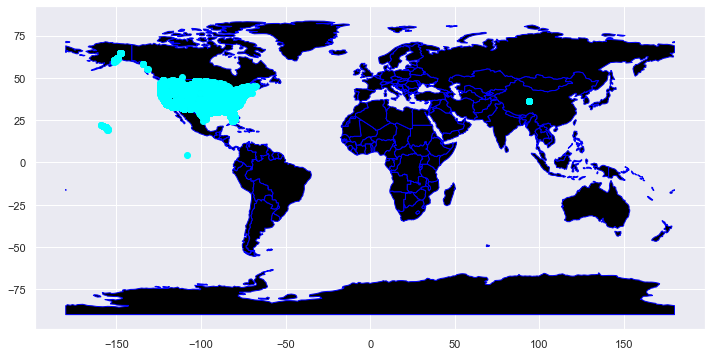

In [121]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(
    color='black', edgecolor='blue', figsize=(12,12))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='cyan')

plt.show()

Vamos a seguir los mismos pasos que explicamos para el data frame de entrenamiento.

In [122]:
outers = dfs[(dfs.lat > meridiano_norte) | (dfs.lat< meridiano_sur) |
             (dfs.long > paralelo_este) | (dfs.long < paralelo_oeste)]

In [123]:
outers.state.value_counts()

ak    196
hi    161
ar     24
il      1
fl      1
ga      1
Name: state, dtype: int64

Los puntos del Estado de Arkansas que se muestran sobre China tiene el mismo problema que los del set anterior. Lo solucionaremos multiplicando los valores por -1. 

In [124]:
# buscamos los registros de Arkansas al este del cuadraro imaginario que trazamos
outers_ar = outers[(outers.state == 'ar') & (outers.long > -67)]

In [125]:
# obtenemos una lista de índices para realizar cambios en el data frame original
indices = outers_ar.long.index.to_list()

In [126]:
# contrastamos la longitud del data frame con la de la lista de índices, deberían tener igual tamaño.
len(outers_ar) - len(indices)

0

In [127]:
# Cambiar los valores del campo 'long' para los índices proporcionados
for indice in indices:
    dfs.at[indice,'long'] = dfs.at[indice,'long'] *-1

In [128]:
# Volvemos a revisar las condiciones una vez que corregimos los primeros datos
outers = dfs[(dfs.lat > meridiano_norte) | (dfs.lat< meridiano_sur) |
             (dfs.long > paralelo_este) | (dfs.long < paralelo_oeste)]

In [129]:
# y volvemos a quitar a los Estados de Alaska y Hawai de nuestra búsqueda
outers = outers[(outers.state != 'ak') & (outers.state != 'hi')]

In [130]:
outers

,region,type,sqfeet,beds,baths,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long,state,geometry
26847,carbondale,townhouse,1150,2,1.0,1,0,0,0,0,4.25383,-108.5150,il,POINT (-108.51500 4.25383)
27538,gainesville,apartment,1631,3,1.0,0,1,0,0,0,50.79300,-111.2260,fl,POINT (-111.22600 50.79300)
29858,valdosta,apartment,850,2,1.0,1,0,0,0,0,24.22880,-98.9422,ga,POINT (-98.94220 24.22880)


Quedan tres registros que no podemos eliminar, pero al ser tan pocos los corregiremos manualmente. Le imputaremos los valores de otra celda de la misma region y Estado.

In [131]:
dfc =dfs[dfs.region == 'valdosta']

In [132]:
dfs.at[26847, 'lat'] = 37.72000
dfs.at[26847, 'long'] = -89.2158

In [133]:
dfs.at[27538, 'lat'] = 29.6808
dfs.at[27538, 'long'] = -82.4303

In [134]:
dfs.at[29858, 'lat'] = 30.8574
dfs.at[29858, 'long'] = -83.2676

Eso concluye la limpieza de los puntos geográficos. Ya podemos eliminar los campos relacionados con la ubicación de los inmuebles.

In [135]:
dfs.drop(columns=['region','lat','long','state', 'geometry'], inplace = True)

## Búsqueda y tratamiento de outliers

Vamos a repetir el procedimiento empleado en el set de entrenamiento. Esto es:
- buscar valores atípicos en las columnas 'sqfeet', 'beds' y 'baths'
- tratarlos usando la regla intercuartil y el método de winsorización

### Columna 'sqfeet'

<AxesSubplot:xlabel='sqfeet', ylabel='Count'>

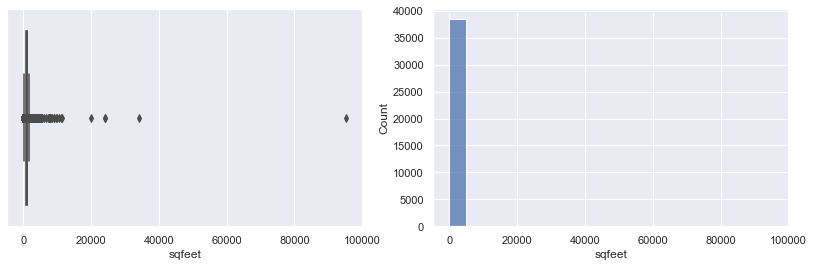

In [136]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='sqfeet', data=dfs, ax=axs[0])
sns.histplot(x='sqfeet', data=dfs, bins=20, kde=False, ax=axs[1])

In [137]:
outliers_low = (dfs['sqfeet'] < get_lower_limit('sqfeet', dfs)).value_counts()
outliers_low

False    38402
True        96
Name: sqfeet, dtype: int64

In [138]:
dfs.sqfeet.describe()

count    38498.000000
mean      1002.062964
std        686.933541
min          0.000000
25%        750.000000
50%        947.000000
75%       1150.000000
max      95242.000000
Name: sqfeet, dtype: float64

__Winsorización__

In [139]:
lim_inferior = get_lower_limit('sqfeet', dfs)
lim_inferior

150.0

In [140]:
lim_superior = get_upper_limit('sqfeet', dfs)
lim_superior

1750.0

In [141]:
dfs['sqfeet'].quantile(0.01)  # el primer cuartil da como valor cero, no es un valor válido en este contexto

345.0

In [142]:
dfs['sqfeet'].quantile(0.96)

1750.0

In [143]:
dfs['sqfeet'] = winsorize(dfs['sqfeet'],(0.01, 0.04)) 

<AxesSubplot:xlabel='sqfeet', ylabel='Count'>

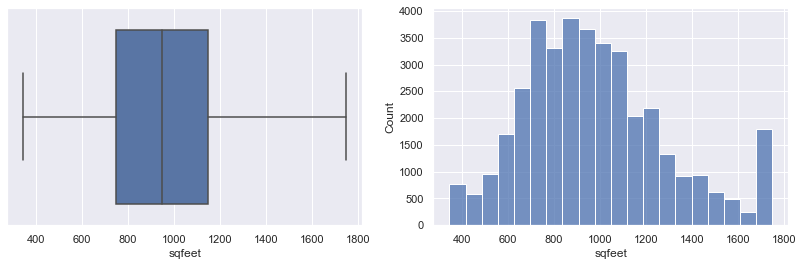

In [144]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='sqfeet', data=dfs, ax=axs[0])
sns.histplot(x='sqfeet', data=dfs, bins=20, kde=False, ax=axs[1])

### Columna 'beds'


<AxesSubplot:xlabel='beds', ylabel='Count'>

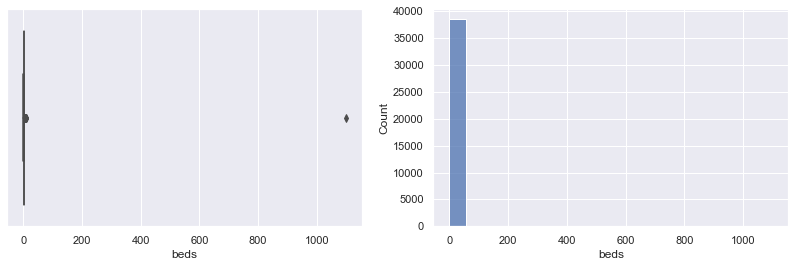

In [145]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='beds', data=dfs, ax=axs[0])
sns.histplot(x='beds', data=dfs, bins=20, kde=False, ax=axs[1])

In [146]:
outliers_low = (dfs['beds'] < get_lower_limit('beds', dfs)).value_counts()
outliers_low

False    38498
Name: beds, dtype: int64

No hay outliers por el lado izquierdo de la data pero si por el derecho.

In [147]:
lim_inferior = get_lower_limit('beds', dfs)
lim_inferior

-0.5

In [148]:
# Redefinimos el límite inferior por ser un valor inválido.
lim_inferior = 0

In [149]:
lim_superior = get_upper_limit('beds', dfs)
lim_superior

3.5

In [150]:
dfs['beds'].quantile(0.00) 

0.0

In [151]:
dfs['beds'].quantile(0.96)

3.0

In [152]:
dfs['beds'] = winsorize(dfs['beds'],(0.00, 0.04)) 

### Columna 'baths'

<AxesSubplot:xlabel='baths', ylabel='Count'>

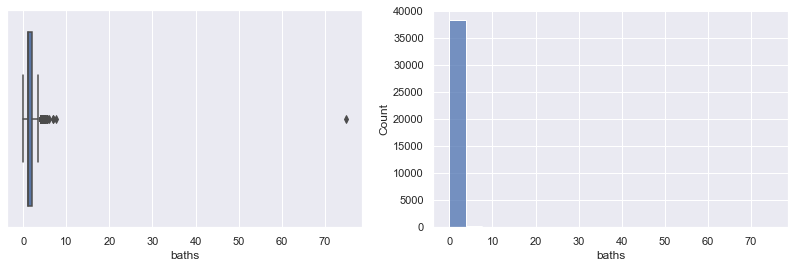

In [153]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='baths', data=dfs, ax=axs[0])
sns.histplot(x='baths', data=dfs, bins=20, kde=False, ax=axs[1])

In [154]:
outliers_low = (dfs['baths'] < get_lower_limit('baths', dfs)).value_counts()
outliers_low

False    38498
Name: baths, dtype: int64

__Winsorización__

In [155]:
lim_inferior = get_lower_limit('baths', dfs)
lim_inferior

-0.5

In [156]:
# Redefinimos el límite inferior por ser un valor inválido
lim_inferior = 0

In [157]:
lim_superior = get_upper_limit('baths', dfs)
lim_superior

3.5

In [158]:
dfs['baths'].quantile(0.00) 

0.0

In [159]:
dfs['baths'].quantile(0.99)

3.0

In [160]:
dfs['baths'] = winsorize(dfs['baths'],(0.00, 0.01)) 

<AxesSubplot:xlabel='baths', ylabel='Count'>

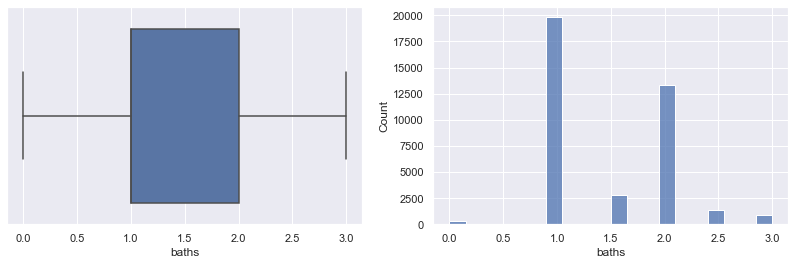

In [161]:
fig, axs = plt.subplots(1, 2,  figsize=(14, 4))
sns.boxplot(x='baths', data=dfs, ax=axs[0])
sns.histplot(x='baths', data=dfs, bins=20, kde=False, ax=axs[1])

## One-Hot Encoding

In [162]:
ohe = OneHotEncoder()          # crear un objeto OneHotEncoder
transformed = ohe.fit_transform(dfs[['type']])  # prepara la columna mencionada

In [163]:
# Codifica a ceros y unos todas las categorías del campo elegido. Luego agrega las nuevas columnas al DF
dfs[ohe.categories_[0]] = transformed.toarray() 

In [164]:
dfs.head()

,type,sqfeet,beds,baths,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,apartment,condo,cottage_cabin,duplex,flat,house,in_law,loft,manufactured,townhouse
0,manufactured,1344,3,2.0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,apartment,1050,2,1.0,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,apartment,1150,2,2.0,1,1,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,apartment,1280,2,2.5,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,apartment,783,2,1.0,1,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
dfs.drop(columns = 'type', inplace = True)

In [166]:
for columna in dfn.columns:
    if columna not in dfs.columns:
        print(columna)

target


In [167]:
dfs['target'] = -1  # Creamos una columna con valores arbitrarios, solo para igualar la estructura del set de entrenamiento 

## Regresión Logística

In [169]:
y_train = dfn.pop('target')
X_train = dfn

In [170]:
y_test = dfs.pop('target')
X_test = dfs

In [171]:
from sklearn.linear_model import LogisticRegression

# Instanciamos el modelo y lo entrenamos

logModel = LogisticRegression(max_iter = 300)

# Lo entrenamos

logModel.fit(X_train,y_train)

LogisticRegression(max_iter=300)

In [172]:
prediccion = logModel.predict(X_test)

In [173]:
type(prediccion)   # vemos que tipo de de objeto es prediccion para poder hacer el dataframe

numpy.ndarray

In [175]:
dfPred = pd.DataFrame(prediccion, columns = ['pred']) 

###  guardamos nuestra predicción en un archivo csv

In [177]:
dfPred.to_csv('Diemale.csv', encoding='utf-8', index=None)

## RandomForest

In [182]:
import numpy as np

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve

In [183]:
# Creamos el modelo
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score= True, random_state = 42)

train_sizes, train_scores, valid_scores = learning_curve(clf, X_train, y_train, 
                                                         train_sizes = np.linspace(0.0001,1,10),
                                                         scoring = 'accuracy', cv=5)

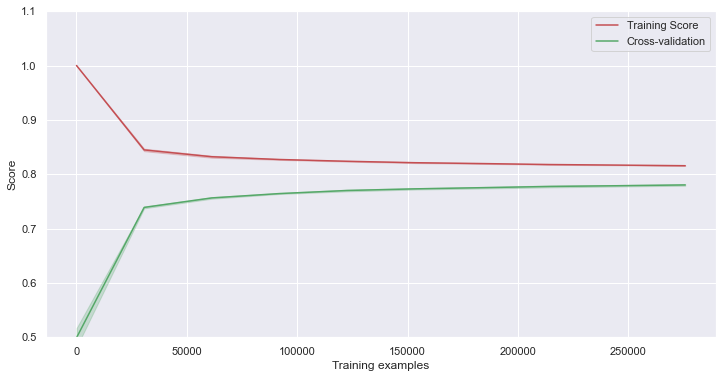

In [184]:
# Graficamos la curva de aprendizaje

plt.figure(figsize = (12,6))
plt.plot(train_sizes, train_scores.mean(axis = 1), color = 'r')
plt.plot(train_sizes, valid_scores.mean(axis = 1), color = 'g')

plt.fill_between(train_sizes, train_scores.mean(axis = 1)- train_scores.std(axis = 1),
                     train_scores.mean(axis = 1)+ train_scores.std(axis = 1), alpha=0.25,
                     color="r")
plt.fill_between(train_sizes, valid_scores.mean(axis = 1) - valid_scores.std(axis = 1),
                     valid_scores.mean(axis = 1) + valid_scores.std(axis = 1), alpha=0.25, color="g")

plt.ylim(0.5,1.1)
plt.legend(['Training Score','Cross-validation'])
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.show()

In [186]:
# lo entrenamos
clf.fit(X_train,y_train)
print("acc: ",clf.score(X_train,y_train))

acc:  0.8138985745200537


Nota: con 30 estimadores el accuracy obtenido fue:  0.8136142907700609.
Podemos notar que no hay mucha diferencia con los 50 iniciales

In [187]:
# crear predicción
prediccion = clf.predict(X_test)

In [188]:
# creamos un data frame con nuestra predicción
dfPred = pd.DataFrame(prediccion, columns = ['pred']) 

In [189]:
# y lo guardamos
dfPred.to_csv('Diemale.csv', encoding='utf-8', index=None)